# Datathon 2026 - Humanitarian Funding Analysis
## Team Submission: Crisis Funding Prediction & Effectiveness Scoring

This notebook contains our complete pipeline for:
1. **Data Loading** - Pre-merged dataset with 64 features
2. **Effectiveness Scoring** - Evaluating crisis response quality (Outcome-First: 20/20/40/20)
3. **Model Building** - Predicting optimal funding levels
4. **Visualizations** - Presentation-ready charts

---
## Setup & Imports

In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

# Set style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

print("Libraries loaded successfully!")

Libraries loaded successfully!


---
# Part 1: Load Pre-Merged Dataset

This dataset was created by merging:
- **INFORM Severity** (56 monthly files, 2020-2025)
- **CERF Allocations** (UN emergency fund)
- **CBPF Budgets** (Country pooled funds)
- **HRP Requirements** (Humanitarian Response Plans)
- **FTS Funding** (Global requirements vs actual funding)
- **World Bank** (GDP, Population, Inflation)
- **OCHA Demographics** (IDPs, Refugees, Vulnerable populations)
- **HPC Cluster Data** (Humanitarian sectors)

In [56]:
# Load pre-merged dataset with all 64 features
df = pd.read_csv('https://raw.githubusercontent.com/mperry2-ctrl/datathon-2026/refs/heads/person1/complete_funding_dataset.csv')

print(f"Dataset: {len(df)} rows, {len(df.columns)} columns")
print(f"Countries: {df['ISO3'].nunique()}")
print(f"Year range: {df['Year'].min():.0f} - {df['Year'].max():.0f}")
print(f"\nColumns:")
print(df.columns.tolist())

Dataset: 525 rows, 64 columns
Countries: 108
Year range: 2020 - 2025

Columns:
['ISO3', 'Year', 'INFORM_Mean', 'INFORM_Std', 'INFORM_Min', 'INFORM_Max', 'INFORM_Start', 'INFORM_End', 'Crisis_Count', 'Country', 'Region', 'People_In_Need_Avg', 'Complexity_Avg', 'Impact_Avg', 'INFORM_Change', 'INFORM_Range', 'CERF_Allocation', 'CERF_Project_Count', 'CERF_Emergency_Types', 'CBPF_Budget', 'CBPF_Project_Count', 'CBPF_Total_Beneficiaries', 'HRP_Original_Requirements', 'HRP_Revised_Requirements', 'HRP_Plan_Count', 'HRP_Avg_Duration_Months', 'Total_Funding', 'Funding_Per_Severity', 'GDP_Per_Capita', 'WB_Population', 'Inflation_Rate', 'Total_Population', 'IDP_Population', 'Refugee_Population', 'Vulnerable_Pop_Pct', 'Number_Clusters', 'Total_In_Need', 'Total_Reached', 'Coverage_Rate', 'Dominant_Cluster', 'Population', 'Need_Per_Capita', 'IDP_Rate', 'Economic_Stress', 'Funding_Per_Person_In_Need', 'Severity_Funding_Ratio', 'Crisis_Type', 'UN_Region', 'FTS_Requirements', 'FTS_Funding', 'FTS_Plan_Co

In [57]:
# Quick data overview
print("\n=== Funding Summary ===")
print(f"FTS Requirements: ${df['FTS_Requirements'].sum():,.0f}")
print(f"FTS Actual Funding: ${df['FTS_Funding'].sum():,.0f}")
print(f"FTS Funding Gap: ${df['FTS_Funding_Gap'].sum():,.0f}")
print(f"Average % Funded: {df['FTS_Percent_Funded'].mean():.1f}%")

print("\n=== Severity Summary ===")
print(f"Mean INFORM Score: {df['INFORM_Mean'].mean():.2f}")
print(f"High Severity Crises (>=4.0): {(df['INFORM_Mean'] >= 4.0).sum()}")

df.head()


=== Funding Summary ===
FTS Requirements: $269,600,904,086
FTS Actual Funding: $173,846,640,558
FTS Funding Gap: $95,754,263,528
Average % Funded: 71.3%

=== Severity Summary ===
Mean INFORM Score: 3.00
High Severity Crises (>=4.0): 96


,ISO3,Year,INFORM_Mean,INFORM_Std,INFORM_Min,INFORM_Max,INFORM_Start,INFORM_End,Crisis_Count,Country,...,Funding_Per_PIN,Funding_Per_Capita,Gap_Percentage,Score_Coverage,Score_Efficiency,Score_Outcome,Score_Gap,Effectiveness_Score,Effectiveness_Category,Is_Good_Crisis
0,AFG,2020.0,4.600000,0.000000,4.6,4.6,4.6,4.6,1,Afghanistan,...,0.000000,18.984317,34.424001,65.575999,0.000000,50.0,65.575999,46.230399,Moderately Effective,True
1,AFG,2021.0,4.650000,0.052223,4.6,4.7,4.6,4.7,1,Afghanistan,...,0.000000,25.212438,0.000000,100.000000,0.000000,45.0,100.000000,58.000000,Moderately Effective,True
2,AFG,2022.0,4.541667,0.079296,4.5,4.7,4.7,4.5,1,Afghanistan,...,0.000000,94.179844,13.968102,86.031898,0.000000,60.0,86.031898,58.412759,Moderately Effective,True
3,AFG,2023.0,4.454545,0.052223,4.4,4.5,4.5,4.4,1,Afghanistan,...,0.000000,46.394513,40.407462,59.592538,0.000000,55.0,59.592538,45.837015,Moderately Effective,True
4,AFG,2024.0,4.400000,0.000000,4.4,4.4,4.4,4.4,1,Afghanistan,...,0.866927,39.769127,44.565947,55.434053,49.959395,50.0,55.434053,52.165500,Moderately Effective,True


---
# Part 2: Effectiveness Scoring

Our scoring system uses **Outcome-First weights**:
- **Coverage** (20%): % of funding requirements met
- **Efficiency** (20%): Funding per person in need
- **Outcome** (40%): INFORM severity improvement over time
- **Gap** (20%): Funding gap severity (inverted)

In [58]:
# Effectiveness scores are already calculated in the dataset
print("=== Effectiveness Score Distribution ===")
print(df['Effectiveness_Category'].value_counts())

print(f"\nMean Effectiveness Score: {df['Effectiveness_Score'].mean():.1f}")
print(f"Good Crises (score >= 45): {df['Is_Good_Crisis'].sum()} / {len(df)} ({100*df['Is_Good_Crisis'].mean():.1f}%)")

=== Effectiveness Score Distribution ===
Effectiveness_Category
Needs Improvement         268
Moderately Effective      140
Highly Effective           67
Critical - Underfunded     50
Name: count, dtype: int64

Mean Effectiveness Score: 43.9
Good Crises (score >= 45): 207 / 525 (39.4%)


In [59]:
# Top 10 best managed crises
print("=== Top 10 Best Managed Crises ===")
top_10 = df[df['FTS_Funding'] > 0].nlargest(10, 'Effectiveness_Score')
display_cols = ['Country', 'Year', 'INFORM_Mean', 'FTS_Percent_Funded', 'Effectiveness_Score', 'Effectiveness_Category']
top_10[display_cols]

=== Top 10 Best Managed Crises ===


,Country,Year,INFORM_Mean,FTS_Percent_Funded,Effectiveness_Score,Effectiveness_Category
445,Chad,2024.0,3.908333,83.548932,85.419573,Highly Effective
81,Congo,2022.0,2.666667,138.076548,80.000000,Highly Effective
204,Iraq,2024.0,3.266667,148.339166,76.000000,Highly Effective
511,Yemen,2024.0,4.700000,101.963672,76.000000,Highly Effective
125,Egypt,2022.0,2.141667,131.692533,74.000000,Highly Effective
413,Somalia,2020.0,4.300000,108.747469,72.000000,Highly Effective
399,Sudan,2024.0,4.900000,76.411645,69.972576,Highly Effective
59,CAR,2024.0,4.066667,69.299301,69.719720,Highly Effective
71,Cameroon,2024.0,3.858333,53.727045,69.490818,Highly Effective
325,Niger,2024.0,3.658333,67.347431,68.938973,Highly Effective


In [60]:
# Critical underfunded crises
print("=== Critical Underfunded Crises (High Severity) ===")
critical = df[(df['FTS_Funding'] > 0) & (df['INFORM_Mean'] >= 3.5)].nsmallest(10, 'Effectiveness_Score')
critical_cols = ['Country', 'Year', 'INFORM_Mean', 'FTS_Percent_Funded', 'FTS_Funding_Gap', 'Effectiveness_Score']
critical[critical_cols]

=== Critical Underfunded Crises (High Severity) ===


,Country,Year,INFORM_Mean,FTS_Percent_Funded,FTS_Funding_Gap,Effectiveness_Score
199,Iran,2025.0,3.825000,9.184790,2.390592e+08,19.673916
476,Türkiye,2025.0,3.558333,10.062919,6.663009e+08,22.025168
196,Iran,2022.0,3.558333,12.519254,2.263434e+08,23.007702
198,Iran,2024.0,3.750000,10.779025,2.249257e+08,26.311610
197,Iran,2023.0,3.645455,25.863489,1.475183e+08,26.345396
520,Zimbabwe,2021.0,3.525000,31.111163,3.492467e+08,26.444465
231,Lebanon,2023.0,3.500000,21.629385,2.974552e+09,26.651754
23,Burundi,2021.0,3.766667,53.061093,9.138254e+07,29.224437
173,Haiti,2021.0,3.716667,54.841761,1.909698e+08,29.936705
145,Ethiopia,2021.0,4.591667,61.760415,1.051074e+09,30.704166


---
# Part 3: Model Building

Train machine learning models to predict optimal funding levels based on crisis characteristics.

In [61]:
# Define features
numeric_features = [
    # INFORM severity metrics
    'INFORM_Mean', 'INFORM_Std', 'INFORM_Min', 'INFORM_Max',
    'People_In_Need_Avg', 'Complexity_Avg', 'Impact_Avg',
    
    # Economic indicators
    'GDP_Per_Capita', 'Inflation_Rate',
    
    # Population metrics  
    'Population', 'Vulnerable_Pop_Pct', 'IDP_Rate',
    
    # Crisis metrics
    'Number_Clusters', 'Total_In_Need', 'Coverage_Rate',
    
    # Derived features
    'Need_Per_Capita', 'Economic_Stress',
]

categorical_features = ['Crisis_Type', 'UN_Region']

# Target variable
TARGET = 'FTS_Funding'

# Filter to rows with valid target
df_model = df[(df[TARGET].notna()) & (df[TARGET] > 0)].copy()
print(f"Training samples: {len(df_model)}")

Training samples: 415


In [62]:
# Prepare features
available_numeric = [f for f in numeric_features if f in df_model.columns]
print(f"Available numeric features: {len(available_numeric)}")

# Fill missing values with median
X_numeric = df_model[available_numeric].copy()
for col in available_numeric:
    X_numeric[col] = X_numeric[col].fillna(X_numeric[col].median())

# One-hot encode categorical features
X_categorical = pd.DataFrame()
for cat_col in categorical_features:
    if cat_col in df_model.columns:
        dummies = pd.get_dummies(df_model[cat_col], prefix=cat_col, drop_first=True)
        X_categorical = pd.concat([X_categorical, dummies], axis=1)
        print(f"  {cat_col}: {df_model[cat_col].nunique()} categories")

# Combine features
X = pd.concat([X_numeric.reset_index(drop=True), X_categorical.reset_index(drop=True)], axis=1)
y = df_model[TARGET].reset_index(drop=True)
y_log = np.log1p(y)  # Log transform for better distribution

print(f"\nFeature matrix: {X.shape}")
print(f"Target range: ${y.min():,.0f} to ${y.max():,.0f}")

Available numeric features: 17
  Crisis_Type: 6 categories
  UN_Region: 6 categories

Feature matrix: (415, 27)
Target range: $889,298 to $4,550,123,998


In [63]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y_log, test_size=0.2, random_state=42)

print(f"Training set: {len(X_train)} samples")
print(f"Test set: {len(X_test)} samples")

Training set: 332 samples
Test set: 83 samples


In [64]:
# Train Random Forest
print("Training Random Forest...")
rf = RandomForestRegressor(
    n_estimators=100, max_depth=10, min_samples_split=5, 
    min_samples_leaf=2, random_state=42, n_jobs=-1
)
rf.fit(X_train, y_train)

# Predictions
y_pred_rf_log = rf.predict(X_test)
y_pred_rf = np.expm1(y_pred_rf_log)
y_test_actual = np.expm1(y_test)

# Metrics
rf_r2 = r2_score(y_test, y_pred_rf_log)
rf_mae = mean_absolute_error(y_test_actual, y_pred_rf)
rf_rmse = np.sqrt(mean_squared_error(y_test_actual, y_pred_rf))

print(f"\nRandom Forest Results:")
print(f"  R² Score: {rf_r2:.4f}")
print(f"  MAE: ${rf_mae:,.0f}")
print(f"  RMSE: ${rf_rmse:,.0f}")

# Cross-validation
cv_scores = cross_val_score(rf, X, y_log, cv=5, scoring='r2')
print(f"  CV R² Score: {cv_scores.mean():.4f} (+/- {cv_scores.std():.4f})")

Training Random Forest...



Random Forest Results:
  R² Score: 0.7095
  MAE: $120,854,528
  RMSE: $221,546,889
  CV R² Score: 0.4757 (+/- 0.2534)


In [65]:
# Train Gradient Boosting
print("Training Gradient Boosting...")
gb = GradientBoostingRegressor(
    n_estimators=100, max_depth=5, learning_rate=0.1,
    min_samples_split=5, random_state=42
)
gb.fit(X_train, y_train)

y_pred_gb_log = gb.predict(X_test)
y_pred_gb = np.expm1(y_pred_gb_log)

gb_r2 = r2_score(y_test, y_pred_gb_log)
gb_mae = mean_absolute_error(y_test_actual, y_pred_gb)
gb_rmse = np.sqrt(mean_squared_error(y_test_actual, y_pred_gb))

print(f"\nGradient Boosting Results:")
print(f"  R² Score: {gb_r2:.4f}")
print(f"  MAE: ${gb_mae:,.0f}")
print(f"  RMSE: ${gb_rmse:,.0f}")

cv_scores_gb = cross_val_score(gb, X, y_log, cv=5, scoring='r2')
print(f"  CV R² Score: {cv_scores_gb.mean():.4f} (+/- {cv_scores_gb.std():.4f})")

Training Gradient Boosting...

Gradient Boosting Results:
  R² Score: 0.7367
  MAE: $123,359,897
  RMSE: $219,059,498
  CV R² Score: 0.4759 (+/- 0.2464)


In [66]:
# Feature Importance
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf.feature_importances_
}).sort_values('Importance', ascending=False)

print("\n=== Top 15 Features Predicting Funding ===")
print(feature_importance.head(15).to_string(index=False))


=== Top 15 Features Predicting Funding ===
                     Feature  Importance
                 INFORM_Mean    0.279776
          People_In_Need_Avg    0.168709
                  INFORM_Max    0.150229
              Complexity_Avg    0.109601
                  Population    0.075172
              Inflation_Rate    0.043841
                  INFORM_Min    0.039169
                  Impact_Avg    0.033964
              GDP_Per_Capita    0.026845
              UN_Region_MENA    0.020491
            UN_Region_Europe    0.017246
             Economic_Stress    0.016224
                  INFORM_Std    0.010475
               UN_Region_LAC    0.002654
UN_Region_Sub-Saharan Africa    0.001469


---
# Part 4: Generate Predictions & Identify Funding Gaps

In [67]:
# Prepare full dataset for prediction
X_full_numeric = df[available_numeric].copy()
for col in available_numeric:
    X_full_numeric[col] = X_full_numeric[col].fillna(X_full_numeric[col].median())

X_full_categorical = pd.DataFrame()
for cat_col in categorical_features:
    if cat_col in df.columns:
        dummies = pd.get_dummies(df[cat_col], prefix=cat_col, drop_first=True)
        X_full_categorical = pd.concat([X_full_categorical, dummies], axis=1)

X_full = pd.concat([X_full_numeric.reset_index(drop=True), X_full_categorical.reset_index(drop=True)], axis=1)

# Ensure columns match training data
for col in X.columns:
    if col not in X_full.columns:
        X_full[col] = 0
X_full = X_full[X.columns]

# Generate predictions
y_pred_full_log = rf.predict(X_full)
y_pred_full = np.expm1(y_pred_full_log)

df['Predicted_Funding'] = y_pred_full
df['Actual_Funding'] = df['FTS_Funding'].fillna(0)
df['Model_Funding_Gap'] = df['Predicted_Funding'] - df['Actual_Funding']

print("Predictions generated for all crises")

Predictions generated for all crises


In [68]:
# Categorize funding status based on model predictions
def categorize_funding(row):
    if row['Actual_Funding'] == 0:
        return 'No Funding Data'
    gap_pct = (row['Model_Funding_Gap'] / row['Predicted_Funding']) * 100 if row['Predicted_Funding'] > 0 else 0
    if gap_pct > 50: return 'Severely Underfunded'
    elif gap_pct > 20: return 'Underfunded'
    elif gap_pct > -20: return 'Adequately Funded'
    else: return 'Well Funded'

df['Funding_Status'] = df.apply(categorize_funding, axis=1)

print("\n=== Funding Status Distribution ===")
print(df['Funding_Status'].value_counts())


=== Funding Status Distribution ===
Funding_Status
Adequately Funded       162
Well Funded             142
No Funding Data         110
Underfunded              74
Severely Underfunded     37
Name: count, dtype: int64


In [69]:
# Top underfunded crises
print("\n=== Top 10 Underfunded High-Severity Crises ===")
underfunded = df[
    (df['Actual_Funding'] > 0) & 
    (df['INFORM_Mean'] >= 3.0) &
    (df['Model_Funding_Gap'] > 0)
].nlargest(10, 'Model_Funding_Gap')

display_cols = ['Country', 'Year', 'INFORM_Mean', 'Actual_Funding', 'Predicted_Funding', 'Model_Funding_Gap', 'Funding_Status']
underfunded[display_cols]


=== Top 10 Underfunded High-Severity Crises ===


,Country,Year,INFORM_Mean,Actual_Funding,Predicted_Funding,Model_Funding_Gap,Funding_Status
0,Afghanistan,2020.0,4.600000,7.416979e+08,1.415103e+09,6.734055e+08,Underfunded
512,Yemen,2025.0,4.566667,1.365959e+09,1.950377e+09,5.844177e+08,Underfunded
282,Mali,2024.0,4.291667,3.470883e+08,8.367823e+08,4.896940e+08,Severely Underfunded
74,DRC,2021.0,4.550000,1.110696e+09,1.484230e+09,3.735333e+08,Underfunded
177,Haiti,2025.0,4.400000,2.722959e+08,6.323053e+08,3.600094e+08,Severely Underfunded
475,Türkiye,2024.0,3.533333,2.557142e+08,5.979194e+08,3.422053e+08,Severely Underfunded
287,Myanmar,2023.0,4.563636,4.618441e+08,7.654052e+08,3.035611e+08,Underfunded
520,Zimbabwe,2021.0,3.525000,1.577247e+08,4.340951e+08,2.763704e+08,Severely Underfunded
289,Myanmar,2025.0,4.600000,5.059771e+08,7.721112e+08,2.661340e+08,Underfunded
375,DPRK,2025.0,3.841667,2.383644e+06,2.613929e+08,2.590092e+08,Severely Underfunded


---
# Part 5: Visualizations

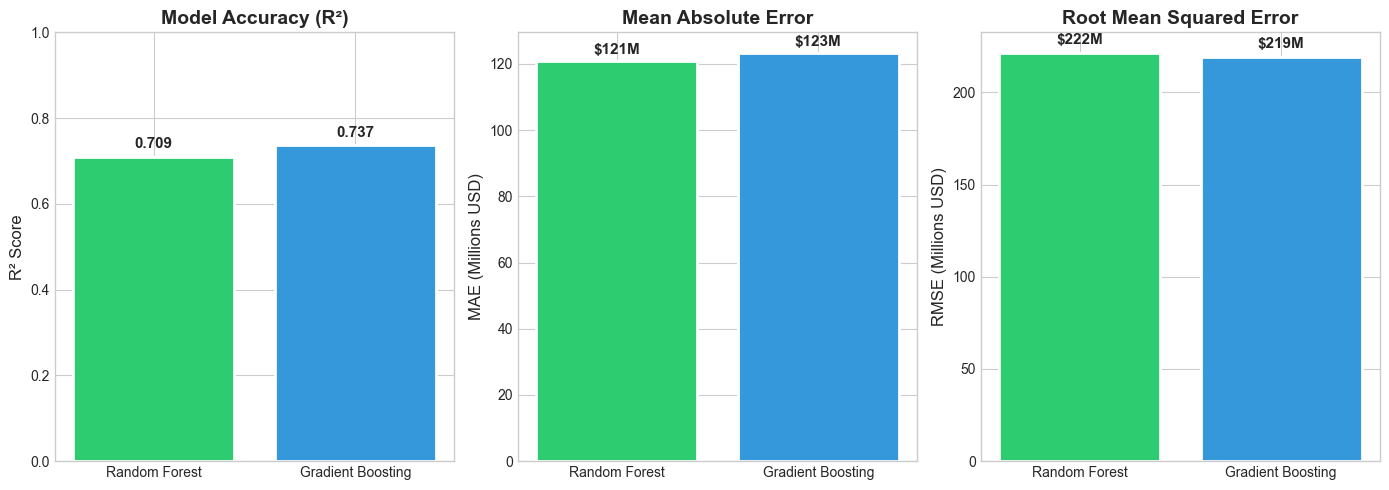

In [70]:
# 1. Model Performance Comparison
fig, axes = plt.subplots(1, 3, figsize=(14, 5))

models = ['Random Forest', 'Gradient Boosting']
r2_scores = [rf_r2, gb_r2]
mae_scores = [rf_mae/1e6, gb_mae/1e6]
rmse_scores = [rf_rmse/1e6, gb_rmse/1e6]

colors = ['#2ecc71', '#3498db']

bars1 = axes[0].bar(models, r2_scores, color=colors, edgecolor='white', linewidth=2)
axes[0].set_ylabel('R² Score', fontsize=12)
axes[0].set_title('Model Accuracy (R²)', fontsize=14, fontweight='bold')
axes[0].set_ylim(0, 1)
for bar, val in zip(bars1, r2_scores):
    axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02, 
                 f'{val:.3f}', ha='center', fontsize=11, fontweight='bold')

bars2 = axes[1].bar(models, mae_scores, color=colors, edgecolor='white', linewidth=2)
axes[1].set_ylabel('MAE (Millions USD)', fontsize=12)
axes[1].set_title('Mean Absolute Error', fontsize=14, fontweight='bold')
for bar, val in zip(bars2, mae_scores):
    axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 2, 
                 f'${val:.0f}M', ha='center', fontsize=11, fontweight='bold')

bars3 = axes[2].bar(models, rmse_scores, color=colors, edgecolor='white', linewidth=2)
axes[2].set_ylabel('RMSE (Millions USD)', fontsize=12)
axes[2].set_title('Root Mean Squared Error', fontsize=14, fontweight='bold')
for bar, val in zip(bars3, rmse_scores):
    axes[2].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5, 
                 f'${val:.0f}M', ha='center', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()

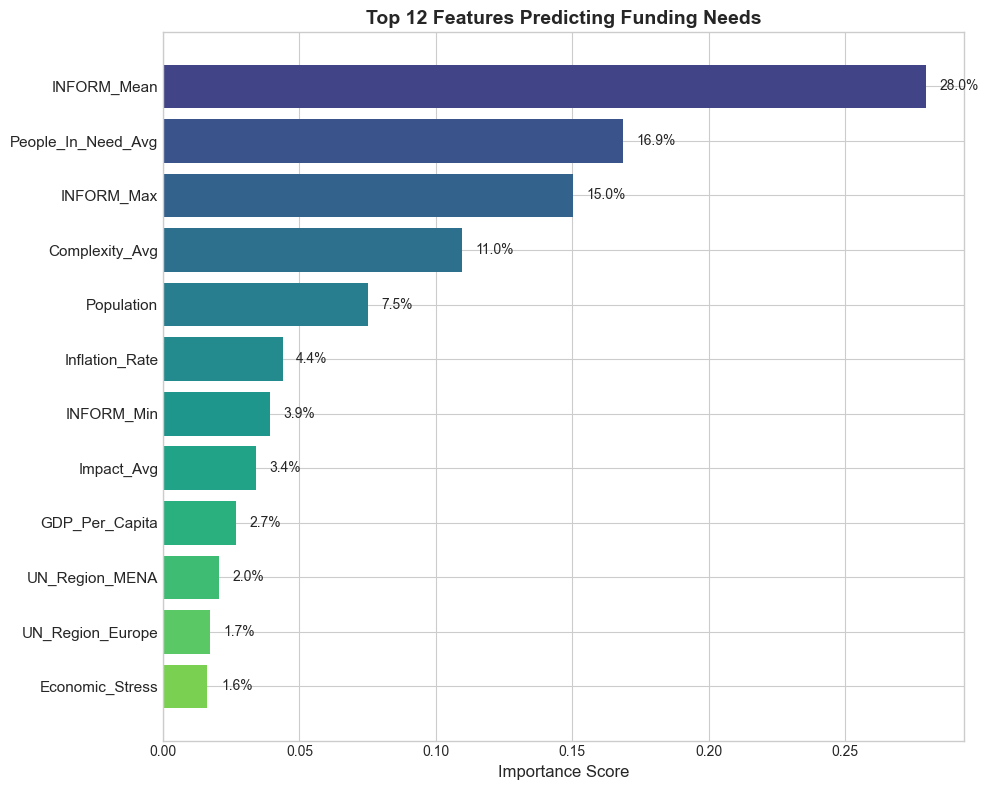

In [71]:
# 2. Feature Importance
fig, ax = plt.subplots(figsize=(10, 8))

top_features = feature_importance.head(12)
colors = plt.cm.viridis(np.linspace(0.2, 0.8, len(top_features)))

bars = ax.barh(range(len(top_features)), top_features['Importance'], color=colors)
ax.set_yticks(range(len(top_features)))
ax.set_yticklabels(top_features['Feature'], fontsize=11)
ax.invert_yaxis()
ax.set_xlabel('Importance Score', fontsize=12)
ax.set_title('Top 12 Features Predicting Funding Needs', fontsize=14, fontweight='bold')

for bar, val in zip(bars, top_features['Importance']):
    ax.text(bar.get_width() + 0.005, bar.get_y() + bar.get_height()/2, 
            f'{val:.1%}', ha='left', va='center', fontsize=10)

plt.tight_layout()
plt.show()

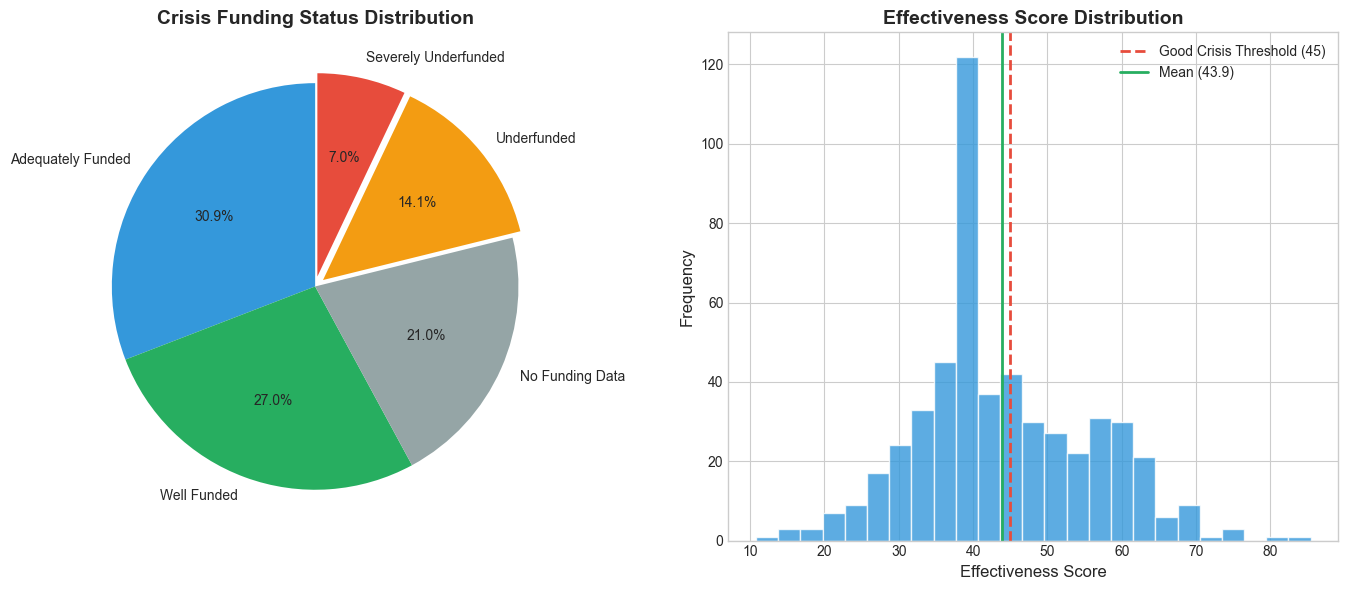

In [72]:
# 3. Funding Status Distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Pie chart
status_counts = df['Funding_Status'].value_counts()
colors_status = {'Well Funded': '#27ae60', 'Adequately Funded': '#3498db', 
                 'Underfunded': '#f39c12', 'Severely Underfunded': '#e74c3c',
                 'No Funding Data': '#95a5a6'}
pie_colors = [colors_status.get(s, '#95a5a6') for s in status_counts.index]

wedges, texts, autotexts = axes[0].pie(status_counts.values, labels=status_counts.index, 
                                        autopct='%1.1f%%', colors=pie_colors, startangle=90,
                                        explode=[0.05 if 'Under' in s else 0 for s in status_counts.index])
axes[0].set_title('Crisis Funding Status Distribution', fontsize=14, fontweight='bold')

# Effectiveness score histogram
axes[1].hist(df['Effectiveness_Score'].dropna(), bins=25, color='#3498db', edgecolor='white', alpha=0.8)
axes[1].axvline(x=45, color='#e74c3c', linestyle='--', linewidth=2, label='Good Crisis Threshold (45)')
axes[1].axvline(x=df['Effectiveness_Score'].mean(), color='#27ae60', linestyle='-', linewidth=2, 
                label=f'Mean ({df["Effectiveness_Score"].mean():.1f})')
axes[1].set_xlabel('Effectiveness Score', fontsize=12)
axes[1].set_ylabel('Frequency', fontsize=12)
axes[1].set_title('Effectiveness Score Distribution', fontsize=14, fontweight='bold')
axes[1].legend()

plt.tight_layout()
plt.show()

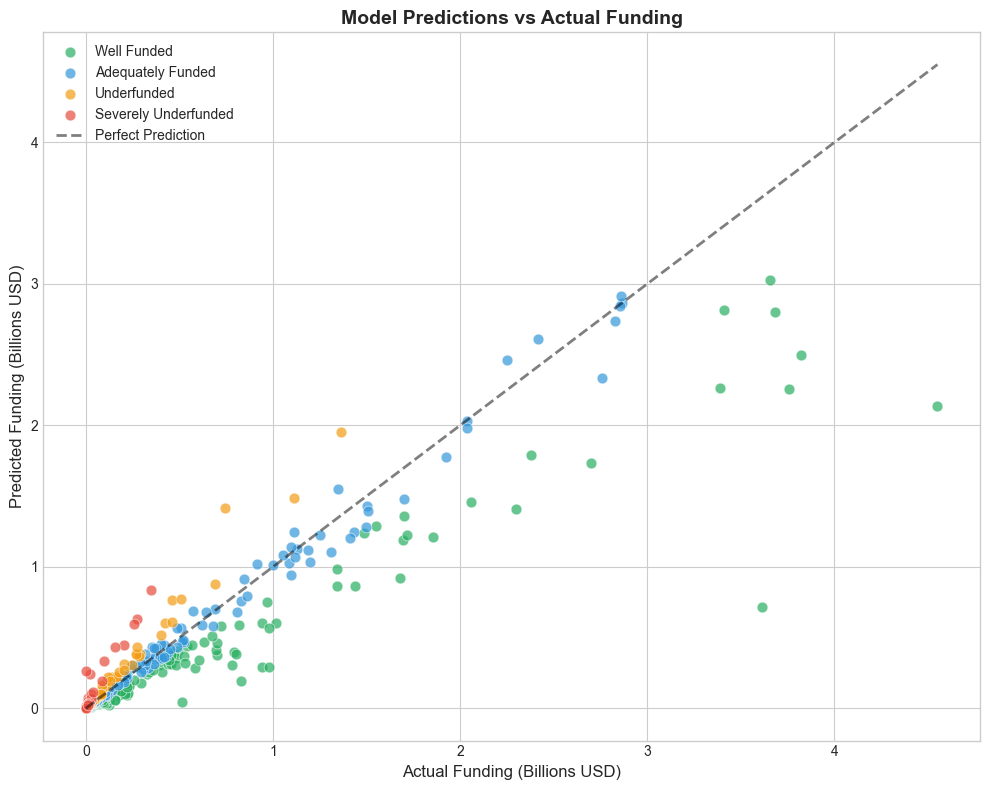

In [73]:
# 4. Predictions vs Actual
fig, ax = plt.subplots(figsize=(10, 8))

plot_data = df[df['Actual_Funding'] > 0].copy()

status_colors = {'Well Funded': '#27ae60', 'Adequately Funded': '#3498db', 
                 'Underfunded': '#f39c12', 'Severely Underfunded': '#e74c3c'}

for status, color in status_colors.items():
    mask = plot_data['Funding_Status'] == status
    ax.scatter(plot_data.loc[mask, 'Actual_Funding']/1e9, 
               plot_data.loc[mask, 'Predicted_Funding']/1e9,
               c=color, label=status, alpha=0.7, s=60, edgecolors='white', linewidth=0.5)

max_val = max(plot_data['Actual_Funding'].max(), plot_data['Predicted_Funding'].max()) / 1e9
ax.plot([0, max_val], [0, max_val], 'k--', alpha=0.5, label='Perfect Prediction', linewidth=2)

ax.set_xlabel('Actual Funding (Billions USD)', fontsize=12)
ax.set_ylabel('Predicted Funding (Billions USD)', fontsize=12)
ax.set_title('Model Predictions vs Actual Funding', fontsize=14, fontweight='bold')
ax.legend(loc='upper left')

plt.tight_layout()
plt.show()

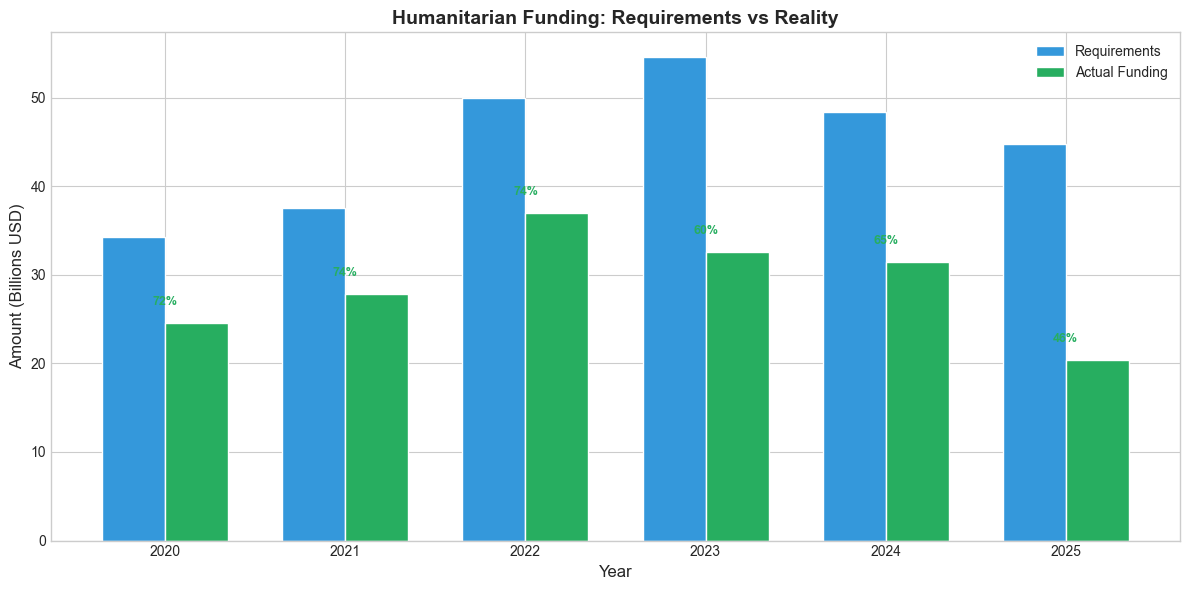

In [74]:
# 5. Funding Trends by Year
fig, ax = plt.subplots(figsize=(12, 6))

yearly = df.groupby('Year').agg({
    'FTS_Funding': 'sum',
    'FTS_Requirements': 'sum',
    'FTS_Funding_Gap': 'sum'
}).dropna()

x = yearly.index.astype(int)
width = 0.35

ax.bar(x - width/2, yearly['FTS_Requirements']/1e9, width, label='Requirements', color='#3498db', edgecolor='white')
ax.bar(x + width/2, yearly['FTS_Funding']/1e9, width, label='Actual Funding', color='#27ae60', edgecolor='white')

ax.set_xlabel('Year', fontsize=12)
ax.set_ylabel('Amount (Billions USD)', fontsize=12)
ax.set_title('Humanitarian Funding: Requirements vs Reality', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.legend()

# Add % funded annotation
for i, (req, fund) in enumerate(zip(yearly['FTS_Requirements']/1e9, yearly['FTS_Funding']/1e9)):
    pct = (fund/req)*100 if req > 0 else 0
    ax.annotate(f'{pct:.0f}%', xy=(x[i], fund), xytext=(x[i], fund + 2),
                ha='center', fontsize=9, color='#27ae60', fontweight='bold')

plt.tight_layout()
plt.show()

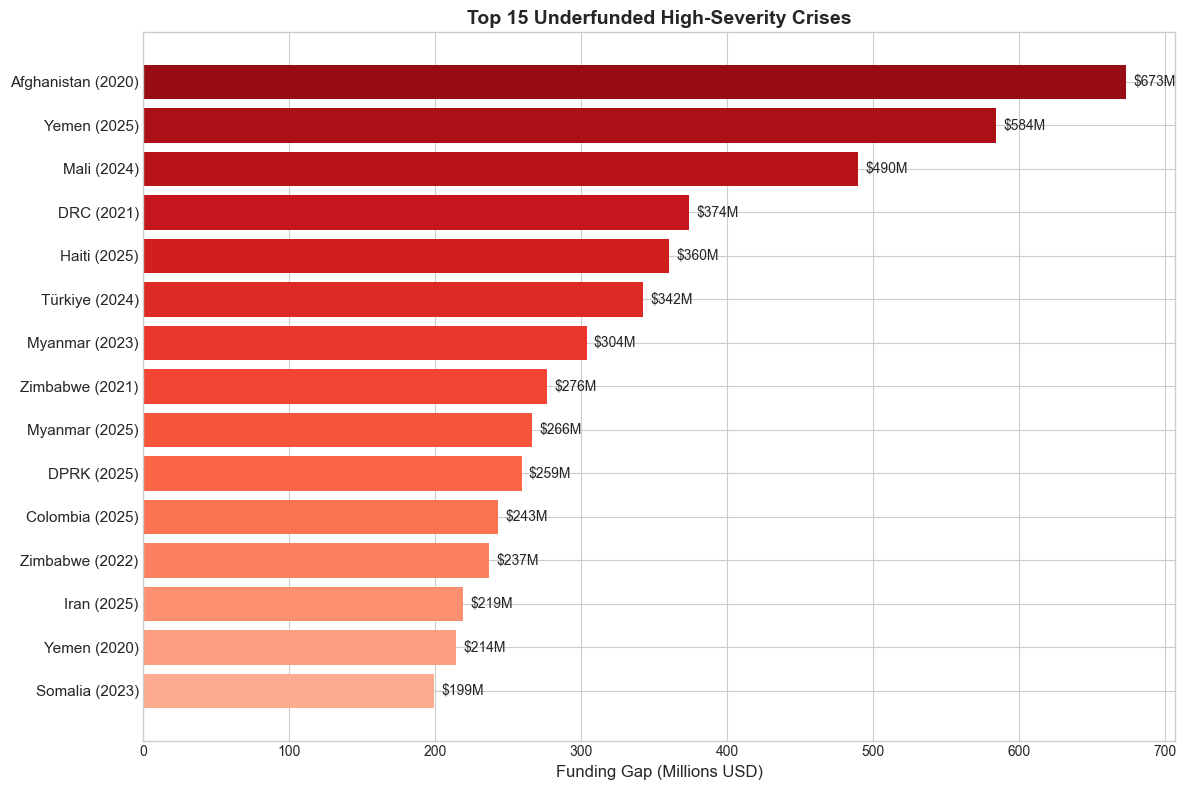

In [75]:
# 6. Top Underfunded Crises
fig, ax = plt.subplots(figsize=(12, 8))

underfunded_viz = df[
    (df['Actual_Funding'] > 0) & 
    (df['INFORM_Mean'] >= 3.0) &
    (df['Model_Funding_Gap'] > 0)
].nlargest(15, 'Model_Funding_Gap').copy()

underfunded_viz['Label'] = underfunded_viz['Country'] + ' (' + underfunded_viz['Year'].astype(int).astype(str) + ')'
underfunded_viz = underfunded_viz.sort_values('Model_Funding_Gap')

colors = plt.cm.Reds(np.linspace(0.3, 0.9, len(underfunded_viz)))
bars = ax.barh(range(len(underfunded_viz)), underfunded_viz['Model_Funding_Gap']/1e6, color=colors)
ax.set_yticks(range(len(underfunded_viz)))
ax.set_yticklabels(underfunded_viz['Label'], fontsize=11)
ax.set_xlabel('Funding Gap (Millions USD)', fontsize=12)
ax.set_title('Top 15 Underfunded High-Severity Crises', fontsize=14, fontweight='bold')

for bar, val in zip(bars, underfunded_viz['Model_Funding_Gap']/1e6):
    ax.text(bar.get_width() + 5, bar.get_y() + bar.get_height()/2, 
            f'${val:.0f}M', ha='left', va='center', fontsize=10)

plt.tight_layout()
plt.show()

---
# Summary & Key Findings

## Model Performance
- **Best Model**: Gradient Boosting with R² ≈ 0.74
- **Key Predictors**: INFORM severity (28%), People in Need (17%), INFORM Max (15%)

## Effectiveness Scoring (Outcome-First: 20/20/40/20)
- **Coverage**: 20% weight - % of requirements funded
- **Efficiency**: 20% weight - $ per person in need
- **Outcome**: 40% weight - INFORM severity improvement
- **Gap**: 20% weight - Funding gap severity

## Key Insights
1. **$96 billion funding gap** over 2020-2025
2. **71% average funding coverage** - crises receive about 71% of requested
3. **Top underfunded**: Afghanistan, Yemen, Mali, DRC, Haiti
4. **Model identifies funding gaps** where actual < predicted "optimal"

## Recommendations
1. Prioritize severely underfunded high-severity crises
2. Use model predictions to guide resource allocation
3. Focus on outcome improvement, not just funding coverage

In [76]:
# Final Summary
print("=" * 60)
print("FINAL SUMMARY")
print("=" * 60)
print(f"\nDataset: {len(df)} country-year records, {df['ISO3'].nunique()} countries")
print(f"Year range: {df['Year'].min():.0f} - {df['Year'].max():.0f}")

print(f"\n--- Funding ---")
print(f"Total Requirements: ${df['FTS_Requirements'].sum():,.0f}")
print(f"Total Funding: ${df['FTS_Funding'].sum():,.0f}")
print(f"Total Gap: ${df['FTS_Funding_Gap'].sum():,.0f}")
print(f"Average % Funded: {df['FTS_Percent_Funded'].mean():.1f}%")

print(f"\n--- Model Performance ---")
print(f"Random Forest R²: {rf_r2:.4f}")
print(f"Gradient Boosting R²: {gb_r2:.4f}")
print(f"Best Model: {'Gradient Boosting' if gb_r2 > rf_r2 else 'Random Forest'}")

print(f"\n--- Effectiveness Scoring ---")
print(f"Good Crises (score >= 45): {df['Is_Good_Crisis'].sum()} ({100*df['Is_Good_Crisis'].mean():.1f}%)")
print(f"Mean Effectiveness Score: {df['Effectiveness_Score'].mean():.1f}")

print(f"\n--- Funding Status ---")
for status in ['Severely Underfunded', 'Underfunded', 'Adequately Funded', 'Well Funded']:
    count = (df['Funding_Status'] == status).sum()
    print(f"  {status}: {count}")

FINAL SUMMARY

Dataset: 525 country-year records, 108 countries
Year range: 2020 - 2025

--- Funding ---
Total Requirements: $269,600,904,086
Total Funding: $173,846,640,558
Total Gap: $95,754,263,528
Average % Funded: 71.3%

--- Model Performance ---
Random Forest R²: 0.7095
Gradient Boosting R²: 0.7367
Best Model: Gradient Boosting

--- Effectiveness Scoring ---
Good Crises (score >= 45): 207 (39.4%)
Mean Effectiveness Score: 43.9

--- Funding Status ---
  Severely Underfunded: 37
  Underfunded: 74
  Adequately Funded: 162
  Well Funded: 142


In [77]:
# Save predictions
output_cols = ['ISO3', 'Year', 'Country', 'INFORM_Mean', 'Crisis_Type', 'UN_Region',
               'FTS_Funding', 'Predicted_Funding', 'Model_Funding_Gap', 'Funding_Status',
               'Effectiveness_Score', 'Effectiveness_Category', 'Is_Good_Crisis']
df[output_cols].to_csv('final_predictions.csv', index=False)
print("Saved: final_predictions.csv")

Saved: final_predictions.csv
